In [1]:
# imports
import pandas as pd
import os
import numpy as np
from Bio import SeqIO
from collections import Counter
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [2]:
# load start and stop for each gene
start_stop_df = pd.read_csv('20230714_Mbel_gene_start_stop.tsv', sep='\t', index_col=0)

In [3]:
braker = pd.read_csv('./braker.gff3_red', sep='\t')
# get gene_ids for each entry
braker['gene_id'] = [i.rsplit('.',1)[0] for i in braker.ID]

# define support functions

In [4]:
def create_and_submit_rho_sbatch(batch, chunk):
    name="RHO_gene_Mbel_batch{batch}.job".format(batch=batch)
    sbatch = [ "#!/bin/bash -l",
                    "#SBATCH -A naiss2023-22-450",
                    "#SBATCH -t 2:0:0 ",
                    "#SBATCH -p core -n 1",
                    "#SBATCH -J {name}".format(name=name),
                    "#SBATCH -o {name}_%j.out".format(name=name),
                    "#SBATCH -e {name}_%j.error".format(name=name),
                    "#SBATCH --get-user-env",
                    "##command underneath this##",
                    "conda activate base",
                    "python get_Mbel_per_gene_rho.py --input {chunk} --flanksize 1e3".format(chunk=chunk)]
    with open(name, 'wt') as handle:
        handle.write("\n".join(sbatch))
    subprocess.call(["chmod", "766", name])
    subprocess.call(["sbatch", name])

In [6]:
def create_and_submit_rho_sbatch(batch, chunk):
    name="RHO_gene_Mbel_batch{batch}.job".format(batch=batch)
    sbatch = [ "#!/bin/bash -l",
                    "#SBATCH -A naiss2023-22-450",
                    "#SBATCH -t 6:0:0 ",
                    "#SBATCH -p core -n 1",
                    "#SBATCH -J {name}".format(name=name),
                    "#SBATCH -o {name}_%j.out".format(name=name),
                    "#SBATCH -e {name}_%j.error".format(name=name),
                    "#SBATCH --get-user-env",
                    "##command underneath this##",
                    "conda activate base",
                    "python get_Mbel_per_gene_rho_with_buffer.py --input {chunk} --flanksize 50000 --flankbuffer 10000".format(chunk=chunk)]
    with open(name, 'wt') as handle:
        handle.write("\n".join(sbatch))
    subprocess.call(["chmod", "766", name])
    subprocess.call(["sbatch", name])

In [72]:
def create_and_submit_sbatch_rho_ex_in(batch, chunk):
    name="RHO_exin_Mbel_batch{batch}.job".format(batch=batch)
    sbatch = [ "#!/bin/bash -l",
                    "#SBATCH -A naiss2023-22-450",
                    "#SBATCH -t 2:0:0 ",
                    "#SBATCH -p core -n 1",
                    "#SBATCH -J {name}".format(name=name),
                    "#SBATCH -o {name}_%j.out".format(name=name),
                    "#SBATCH -e {name}_%j.error".format(name=name),
                    "#SBATCH --get-user-env",
                    "##command underneath this##",
                    "conda activate base",
                    "python get_Mbel_rho_exin.py --input {chunk}".format(chunk=chunk)]
    with open(name, 'wt') as handle:
        handle.write("\n".join(sbatch))
    subprocess.call(["chmod", "766", name])
    subprocess.call(["sbatch", name])

In [7]:
#split into chunks and write them
chunk_n = 20
ss_split = np.array_split(start_stop_df, chunk_n)

In [8]:
for i, k in enumerate(ss_split):
    #print(i)
    chunkname = "ss_chunks/ss_chunk{chunk_i}.chunk".format(chunk_i=i)
    #k.to_csv(chunkname, sep='\t')
    create_and_submit_rho_sbatch(batch=i, chunk=chunkname)

Submitted batch job 40093949
Submitted batch job 40093950
Submitted batch job 40093951
Submitted batch job 40093952
Submitted batch job 40093953
Submitted batch job 40093954
Submitted batch job 40093955
Submitted batch job 40093956
Submitted batch job 40093957
Submitted batch job 40093958
Submitted batch job 40093959
Submitted batch job 40093960
Submitted batch job 40093961
Submitted batch job 40093962
Submitted batch job 40093963
Submitted batch job 40093964
Submitted batch job 40093965
Submitted batch job 40093966
Submitted batch job 40093967
Submitted batch job 40093968


In [59]:
braker_exin = braker.loc[braker.Type.isin(['exon', 'intron'])]

In [63]:
#split into chunks and write them
chunk_n = 200
braker_split = np.array_split(braker_exin, chunk_n)

In [75]:
for i, k in enumerate(braker_split):
    #print(i)
    chunkname = "exin_chunks/braker_chunk_{chunk_i}.gff3_chunk".format(chunk_i=i)
    #k.to_csv(chunkname, sep='\t')
    create_and_submit_sbatch_rho_ex_in(batch=i, chunk=chunkname)

Submitted batch job 39840983
Submitted batch job 39840984
Submitted batch job 39840985
Submitted batch job 39840986
Submitted batch job 39840987
Submitted batch job 39840988
Submitted batch job 39840989
Submitted batch job 39840990
Submitted batch job 39840991
Submitted batch job 39840992
Submitted batch job 39840993
Submitted batch job 39840994
Submitted batch job 39840995
Submitted batch job 39840996
Submitted batch job 39840997
Submitted batch job 39840998
Submitted batch job 39840999
Submitted batch job 39841000
Submitted batch job 39841001
Submitted batch job 39841002
Submitted batch job 39841003
Submitted batch job 39841004
Submitted batch job 39841005
Submitted batch job 39841006
Submitted batch job 39841007
Submitted batch job 39841008
Submitted batch job 39841009
Submitted batch job 39841010
Submitted batch job 39841011
Submitted batch job 39841012
Submitted batch job 39841013
Submitted batch job 39841014
Submitted batch job 39841015
Submitted batch job 39841016
Submitted batc

In [79]:
rho_chunks =  [ i for i in os.listdir("./ss_chunks") if i.endswith(".rho")]
rho_chunks = [i for i in rho_chunks if not i.startswith('test')]
rho_chunks_df = pd.concat([pd.read_csv(os.path.join("./ss_chunks",i), sep='\t', header=None) for i in rho_chunks])

In [81]:
rho_chunks_df.columns = ['scaffold', 'weighted_mean_rho_gene', 'weighted_mean_rho_uflank', 'weighted_mean_rho_dflank', 'gene_id']


In [82]:
rho_chunks_df.to_csv('./20230717_Mbel_rho_per_gene_and_1e3flankingregions.tsv', sep='\t')

In [96]:
rho_chunks_df = rho_chunks_df.replace('no_overlap_bin', np.nan)
rho_chunks_df[['weighted_mean_rho_gene', 'weighted_mean_rho_uflank', 'weighted_mean_rho_dflank']] = rho_chunks_df[['weighted_mean_rho_gene', 'weighted_mean_rho_uflank', 'weighted_mean_rho_dflank']].astype(float)

In [97]:
rho_chunks_dfmelt = rho_chunks_df.melt(id_vars=['gene_id', 'scaffold'], value_vars=['weighted_mean_rho_gene', 'weighted_mean_rho_uflank', 'weighted_mean_rho_dflank',] )


In [91]:
rho_chunks_exin =  [ i for i in os.listdir("./exin_chunks") if i.endswith(".rho")]
rho_chunks_exin = [i for i in rho_chunks_exin if not i.startswith('test')]
rho_chunks_exin_df = pd.concat([pd.read_csv(os.path.join("./exin_chunks/",i), sep=',', index_col=0, header=None) for i in rho_chunks_exin])
rho_chunks_exin_df.columns = list(braker_exin.columns)+['RHO']
rho_chunks_exin_df.to_csv('./20230717_Mbel_rho_exons_and_introns.tsv', sep='\t')

,Scaffold,Type,Start_pos,End_pos,ID,gene_id,RHO
0,,,,,,,
786568,scaffold116,exon,4578,4727,g11107.t1.exon2,g11107.t1,0.9311
786572,scaffold41,exon,3949621,3949940,g13973.t1.exon1,g13973.t1,no_overlap_bin
786573,scaffold41,intron,3949941,3952358,g13973.t1.intron1,g13973.t1,no_overlap_bin
786575,scaffold41,exon,3952359,3952557,g13973.t1.exon2,g13973.t1,no_overlap_bin
786576,scaffold41,intron,3952558,3956775,g13973.t1.intron2,g13973.t1,no_overlap_bin
...,...,...,...,...,...,...,...
385271,scaffold12,intron,2918293,2918421,g7807.t2.intron24,g7807.t2,0.173517734375
385273,scaffold12,exon,2918422,2918582,g7807.t2.exon25,g7807.t2,0.17229025
385274,scaffold12,intron,2918583,2919652,g7807.t2.intron25,g7807.t2,0.7496895322731525


In [93]:
rho_chunks_exin_df.RHO = rho_chunks_exin_df.RHO.replace('no_overlap_bin', np.nan).astype(float)

In [ ]:
rho_chunks_exin_df['RHO_lim20']  = [i if i<20 else 20 for i in rho_chunks_exin_df['RHO']]

In [ ]:
# make figures

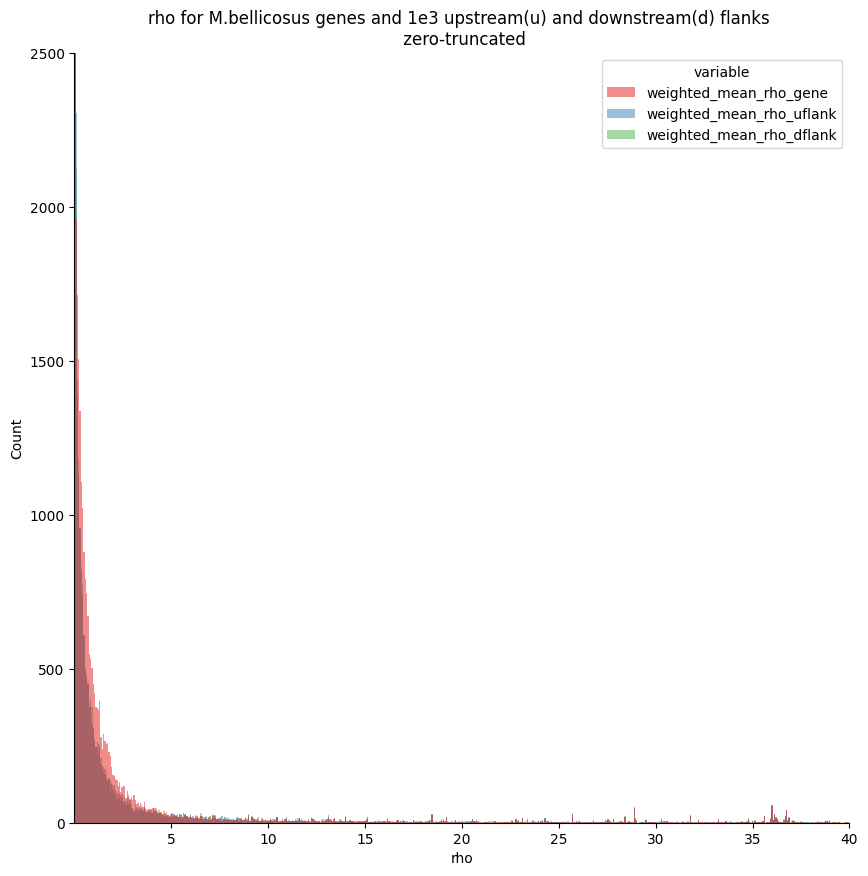

In [102]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,10))
sns.histplot(data=rho_chunks_dfmelt, x="value", hue="variable",linewidth=0, palette = ['#e41a1c','#377eb8','#4daf4a'])

ax.set_xlim(0.01,40)
ax.set_ylim(0.00,2500)
ax.set_title('rho for M.bellicosus genes and 1e3 upstream(u) and downstream(d) flanks \n zero-truncated')
ax.set_xlabel('rho')

sns.despine()
plt.show()

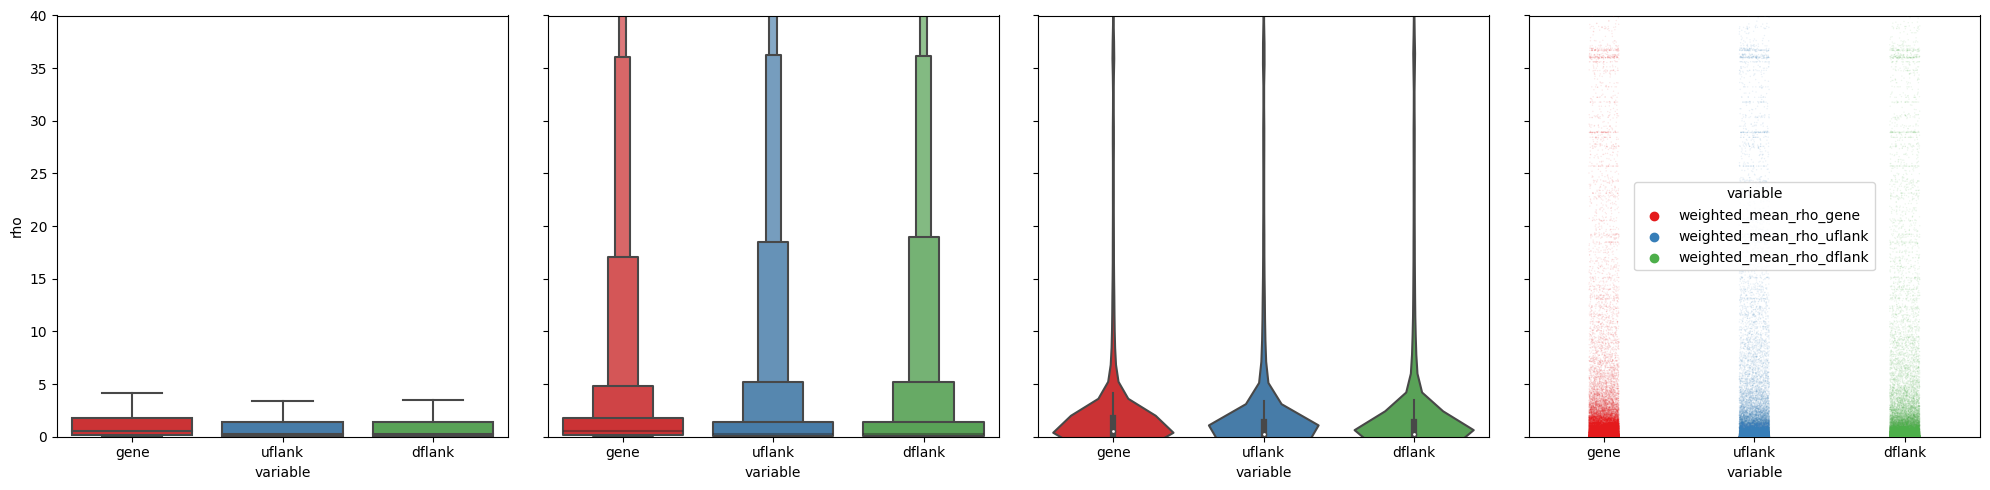

In [103]:

fig, (ax, ax1, ax2, ax3) = plt.subplots(ncols=4, nrows=1, figsize=(20,5), sharey=True, sharex=True)
sns.boxplot(data=rho_chunks_dfmelt, y="value",x='variable', palette = ['#e41a1c','#377eb8','#4daf4a'], ax=ax, fliersize=0)
sns.boxenplot(data=rho_chunks_dfmelt, y="value",x='variable', palette = ['#e41a1c','#377eb8','#4daf4a'], ax=ax1)
sns.violinplot(data=rho_chunks_dfmelt, y="value",x='variable', palette = ['#e41a1c','#377eb8','#4daf4a'], ax=ax2)
sns.stripplot(data=rho_chunks_dfmelt, y="value",x='variable', hue='variable', palette = ['#e41a1c','#377eb8','#4daf4a'], ax=ax3, alpha=0.1, s=1)


ax.set_xticklabels(['gene', 'uflank', 'dflank'])
ax.set_ylabel('rho')
ax1.set_ylabel(' ')
ax2.set_ylabel(' ')
ax3.set_ylabel(' ')

ax.set_ylim(0,40)

plt.tight_layout()
plt.show()

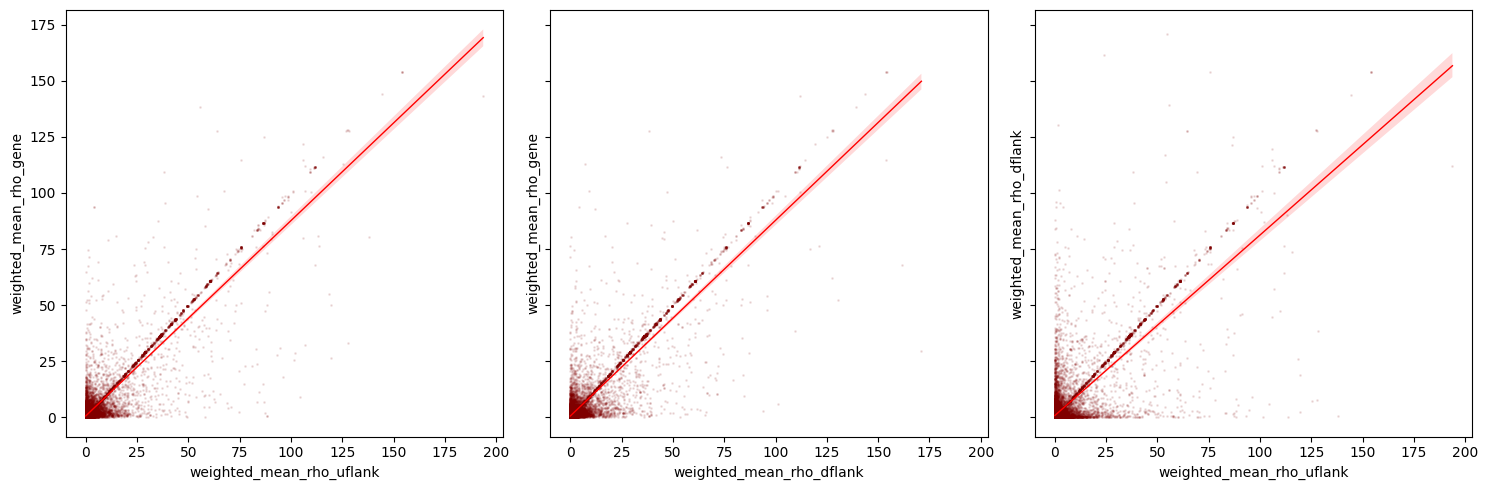

In [118]:
fig, (ax, ax1, ax2) = plt.subplots(ncols=3, nrows=1, figsize=(15,5), sharey=True, sharex=True)

sns.regplot(data=rho_chunks_df, x="weighted_mean_rho_uflank", y="weighted_mean_rho_gene", ax=ax, line_kws={'color':'red', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'maroon'} )
sns.regplot(data=rho_chunks_df, x="weighted_mean_rho_dflank", y="weighted_mean_rho_gene", ax=ax1, line_kws={'color':'red', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'maroon'} )
sns.regplot(data=rho_chunks_df, x="weighted_mean_rho_uflank", y="weighted_mean_rho_dflank", ax=ax2, line_kws={'color':'red', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'maroon'} )

plt.tight_layout()
#ax.set_ylim(0,3)
#ax.set_xlim(0,3)

plt.show()

In [120]:
rho_chunks_exin_df['RHO_lim20']  = [i if i<20 else 20 for i in rho_chunks_exin_df['RHO']]

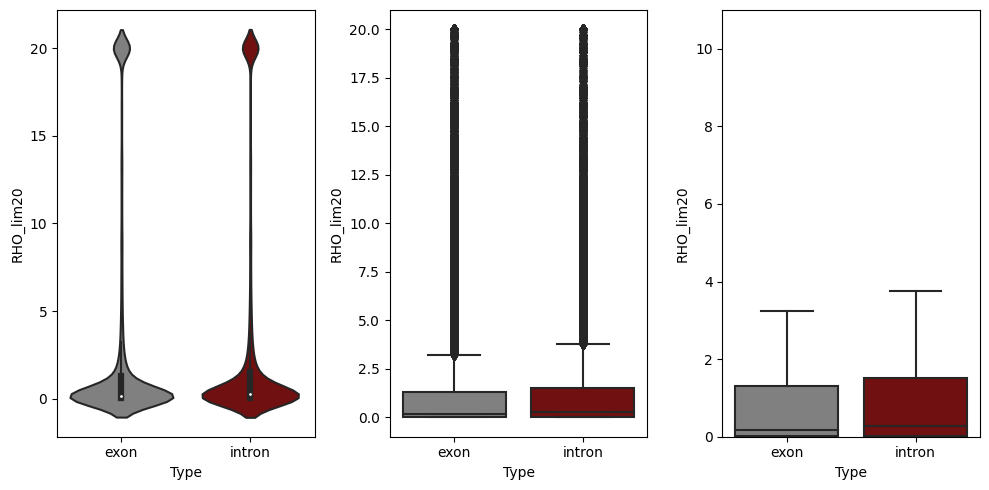

In [121]:
fig, (ax, ax1, ax2) = plt.subplots(ncols=3, nrows=1, figsize=(10,5), sharey=False)

sns.violinplot(data=rho_chunks_exin_df, x='Type', y='RHO_lim20', ax=ax, palette=['grey', 'maroon'])
sns.boxplot(data=rho_chunks_exin_df, x='Type', y='RHO_lim20', ax=ax1,palette=['grey', 'maroon'])
sns.boxplot(data=rho_chunks_exin_df, x='Type', y='RHO_lim20', ax=ax2, fliersize=0,palette=['grey', 'maroon'])

ax2.set_ylim(0,11)
plt.tight_layout()
plt.show()

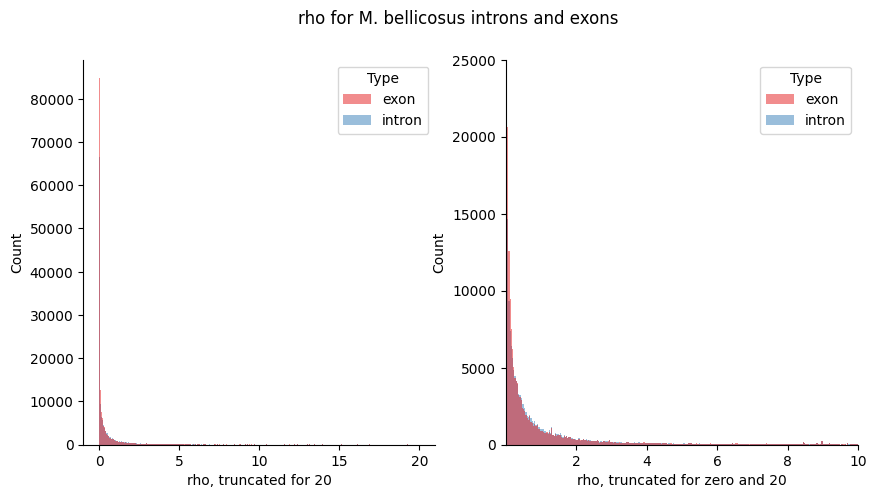

In [124]:
fig, (ax, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
sns.histplot(data=rho_chunks_exin_df, x="RHO_lim20", hue="Type",linewidth=0, palette = ['#e41a1c','#377eb8'] ,ax=ax)
#x.set_xlim(0,2)
fig.suptitle('rho for M. bellicosus introns and exons')
ax.set_xlabel('rho, truncated for 20')

sns.histplot(data=rho_chunks_exin_df, x="RHO_lim20", hue="Type",linewidth=0, palette = ['#e41a1c','#377eb8'] ,ax=ax1)
ax1.set_xlim(0.001,10)
ax1.set_ylim(0,25000)
ax1.set_xlabel('rho, truncated for zero and 20')

sns.despine()
plt.show()

,Scaffold,Type,Start_pos,End_pos,ID,gene_id,RHO
0,,,,,,,
786568,scaffold116,exon,4578,4727,g11107.t1.exon2,g11107.t1,0.931100
786572,scaffold41,exon,3949621,3949940,g13973.t1.exon1,g13973.t1,NaN
786573,scaffold41,intron,3949941,3952358,g13973.t1.intron1,g13973.t1,NaN
786575,scaffold41,exon,3952359,3952557,g13973.t1.exon2,g13973.t1,NaN
786576,scaffold41,intron,3952558,3956775,g13973.t1.intron2,g13973.t1,NaN
...,...,...,...,...,...,...,...
385271,scaffold12,intron,2918293,2918421,g7807.t2.intron24,g7807.t2,0.173518
385273,scaffold12,exon,2918422,2918582,g7807.t2.exon25,g7807.t2,0.172290
385274,scaffold12,intron,2918583,2919652,g7807.t2.intron25,g7807.t2,0.749690


In [104]:
rho_chunks_exin_df['RHO'].mean()

3.503446381640527

In [107]:
rho_chunks_exin_df.groupby('Type')['RHO'].mean()

Type
exon      3.508157
intron    3.498127
Name: RHO, dtype: float64

In [108]:
rho_chunks_exin_df.groupby('Type')['RHO'].sem()

Type
exon      0.021512
intron    0.022177
Name: RHO, dtype: float64

In [109]:
rho_chunks_exin_df.groupby('Type')['RHO'].std()

Type
exon      10.836931
intron    10.512917
Name: RHO, dtype: float64

In [110]:
rho_chunks_dfmelt.groupby('variable')['value'].mean()

variable
weighted_mean_rho_dflank    3.793604
weighted_mean_rho_gene      3.833009
weighted_mean_rho_uflank    3.777496
Name: value, dtype: float64

In [111]:
rho_chunks_dfmelt.groupby('variable')['value'].sem()

variable
weighted_mean_rho_dflank    0.067597
weighted_mean_rho_gene      0.065353
weighted_mean_rho_uflank    0.067752
Name: value, dtype: float64

In [112]:
rho_chunks_dfmelt.groupby('variable')['value'].std()

variable
weighted_mean_rho_dflank    11.521898
weighted_mean_rho_gene      11.139799
weighted_mean_rho_uflank    11.547933
Name: value, dtype: float64

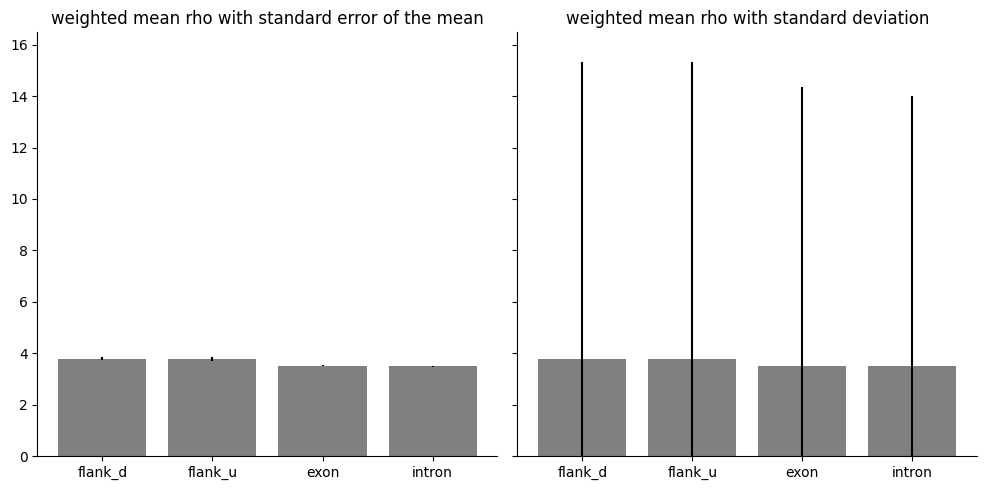

In [113]:
fig, (ax, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(10,5), sharey=True)
ax.bar(height = [3.793604,3.777496,3.508157,3.498127 ], x= ['flank_d', 'flank_u', 'exon', 'intron'], yerr = [0.067597,0.067752,0.021512,0.022177], color='grey')
ax1.bar(height = [3.793604,3.777496,3.508157,3.498127 ], x= ['flank_d', 'flank_u', 'exon', 'intron'], yerr = [11.521898,11.547933,10.836931,10.512917], color='grey')

ax.set_title("weighted mean rho with standard error of the mean")
ax1.set_title("weighted mean rho with standard deviation")
sns.despine()
plt.tight_layout()
ax.set_ylim(0,)
plt.show()

In [115]:
fd = rho_chunks_dfmelt.loc[rho_chunks_dfmelt.variable =='weighted_mean_rho_dflank' ]['value'].dropna()
fu = rho_chunks_dfmelt.loc[rho_chunks_dfmelt.variable =='weighted_mean_rho_uflank' ]['value'].dropna()
ex = rho_chunks_exin_df.loc[rho_chunks_exin_df.Type =='exon']['RHO'].dropna()
intr = rho_chunks_exin_df.loc[rho_chunks_exin_df.Type =='intron']['RHO'].dropna()

In [116]:
thsd = scipy.stats.tukey_hsd(fd, fu, ex, intr)

In [117]:
print(thsd)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.016     0.998    -0.214     0.246
 (0 - 2)      0.285     0.000     0.114     0.457
 (0 - 3)      0.295     0.000     0.123     0.468
 (1 - 0)     -0.016     0.998    -0.246     0.214
 (1 - 2)      0.269     0.000     0.098     0.441
 (1 - 3)      0.279     0.000     0.107     0.452
 (2 - 0)     -0.285     0.000    -0.457    -0.114
 (2 - 1)     -0.269     0.000    -0.441    -0.098
 (2 - 3)      0.010     0.989    -0.070     0.090
 (3 - 0)     -0.295     0.000    -0.468    -0.123
 (3 - 1)     -0.279     0.000    -0.452    -0.107
 (3 - 2)     -0.010     0.989    -0.090     0.070

